# Assignment 2

In this assignment the goal is to be able to price a game based on an image. This will be done using a convolutional neural network. In what follows we first performed some ...

To Do:
- Do a round of fine-tuning of the entire model
- Add a base-line
    take the average from the training data and use it on the validation data, we want to improve this with our model


## Train, validation, test split and data pre-processing

The first step requires loading in the images and the json file that includes the price for each game and the corresponding screenshots. <br> <br>


In [64]:
#Load the following packages:
import os
import json
import numpy as np
import pandas as pd
import keras
import matplotlib.pyplot as plt
import tensorflow
from sklearn.model_selection import train_test_split

# Set the location of where the images are stored. Adjust if necessary
image_location = '/Users/sarahguilliams/Desktop/Advanced Analytics in a Big Data World/Assignment2/images'

# Load the json datafile
file_path = "dataset.json"

# Open the JSON file and load its contents
with open(file_path, 'r') as file:
    data = json.load(file)
data1 = pd.DataFrame(data)



The next part of the pre-processing requires a check for corrupted images. These images needed to be removed as they caused errors when fitting the model. Using the code below a check was perfomed to assess which images were corrupted. In the end 41 corrupted images were removed from the images folder.

In [65]:
import os
from PIL import Image
folder_path = '/Users/sarahguilliams/Desktop/Advanced Analytics in a Big Data World/Assignment2/images'
extensions = []
for fldr in os.listdir(folder_path):
    if fldr == '.DS_Store':
        continue
    file_path = os.path.join(folder_path, fldr)
    print('** Path: {}  **'.format(file_path), end="\r", flush=True)
    im = Image.open(file_path)
    rgb_im = im.convert('RGB')
    if fldr.split('.')[1] not in extensions:
        extensions.append(fldr.split('.')[1])


KeyboardInterrupt: 

These 41 corrupted images were removed from the folder. For some games, this ended up removing all images for the game. Therefore, the games that had a corrupted image were removed. This prevents the possibility of games with all corrupted images ending in the test set and potentially _____ of our result.

In [66]:
import pandas as pd

# create a sample data frame
df = pd.DataFrame({'Name': ['John Doe', 'Jane Doe', 'Mark Johnson', 'Sarah Smith', 'Adam Smith'],
                   'Age': [25, 30, 40, 20, 35],
                   'Gender': ['Male', 'Female', 'Male', 'Female', 'Male']})

# display the original data frame
print("Original Data Frame:")
print(df.dtypes)

# filter the rows that contain the substring
substring = 'Smith'
filter = df['Name'].str.contains(substring)
print(filter)
filtered_df = df[~filter]

# display the filtered data frame
print(f"\nData Frame after removing rows that contain '{substring}' in 'Name' column:")
print(filtered_df)

Original Data Frame:
Name      object
Age        int64
Gender    object
dtype: object
0    False
1    False
2    False
3     True
4     True
Name: Name, dtype: bool

Data Frame after removing rows that contain 'Smith' in 'Name' column:
           Name  Age  Gender
0      John Doe   25    Male
1      Jane Doe   30  Female
2  Mark Johnson   40    Male


In [41]:
# Manually provide a list of corrupted screenshots.
corrupted_screenshots = [
    '1029210_ss_7096afc94036153001b266a75253fb6abdd03c54.1920x1080.jpg',
    '1029210_ss_ddf975e414f08a0bb419818d2cd94be4ebff6db9.1920x1080.jpg',
    '2445340_ss_fdbf4004c0087b96c3a8ebb1152179b3563d7091.1920x1080.jpg',
    '2744670_ss_beb7ded23e2d824ca7d80272d706ee08e6af21d8.1920x1080.jpg',
    '2744670_ss_c300132b42d284bed90332afa50d6fa469ece912.1920x1080.jpg', 
    '2744670_ss_e19d879e2fce6c91e78e7f983a3540f789efa484.1920x1080.jpg',
    '2744730_ss_3fe2c9952214fdfe7d78906609dcd1f217bbff65.1920x1080.jpg',
    '2744730_ss_05ee36cd4dcc206e6f053cc14a6c84a73f2fc406.1920x1080.jpg',
    '2744730_ss_7dcf667813fbd44e61e4a772828fde5dd94fd9cc.1920x1080.jpg',
    '2744730_ss_9e055a32329bd7a9a81d5101bd3980a2b517b398.1920x1080.jpg',
    '2744730_ss_f4e3ef6ecac8026a5d237561ac2cb47bea993510.1920x1080.jpg',
    '2744840_ss_3cb8d2c6b795f00815a177547c931d2e59747c9c.1920x1080.jpg',
    '2744840_ss_3cd4c192c3b725de016c8c94fdcad8ad35cac377.1920x1080.jpg',
    '2744840_ss_72f2e2286a826c02423d760d51b36dc50e039e1c.1920x1080.jpg',
    '2744840_ss_3387a3b945dddcaa7e1acc29d2e91b4cf2b479fb.1920x1080.jpg',
    '2744840_ss_5704aa3e754f7fd64e0a56a890217230ad970f95.1920x1080.jpg',
    '2744840_ss_9861fdb7a393238a37c2c14e67fb43a277e571d2.1920x1080.jpg',
    '2744840_ss_bfff2b970adea1a853baab4108fab4ef53f26659.1920x1080.jpg',
    '2744840_ss_dbe32bd3d446243d2476cc0f3188f6c1746d8821.1920x1080.jpg',
    '2744840_ss_ea72a9a1679e8e076c1aa1f62dc67d59b7b5c773.1920x1080.jpg',
    '2744840_ss_fef3288db4f2f2fa1214e0d63074fda5c8023590.1920x1080.jpg',
    '2744890_ss_0f1070ff36acb5b179cd5d644742c712f2758f7a.1920x1080.jpg',
    '2744890_ss_12f5c79481bd54534572fbf8a7e8075f0706cec9.1920x1080.jpg',
    '2744890_ss_38ad40c0189c8d58bb3f92ea53f0f6606e856379.1920x1080.jpg',
    '2744890_ss_093461c3d0ab1501406d654cbb2c38d8be6536e7.1920x1080.jpg',
    '2744890_ss_6550307213cc0b6a64c52feef0890760d9d75093.1920x1080.jpg',
    '2744890_ss_abf20b071e583cc20089ee502537e42c55fc26e2.1920x1080.jpg',
    '2744890_ss_d9ac38eeaefaf285a7c8618b18e0bbacbccd54f4.1920x1080.jpg',
    '2744890_ss_d59ced9f0c52e4f667aa7c4d70fa7de1f7f5fe36.1920x1080.jpg',
    '2744890_ss_dd28096d2091c6668a7a631f21649fd75ac7cc49.1920x1080.jpg',
    '2744890_ss_f82bd8c5e097766a7e00493554ea96c0a3e087ed.1920x1080.jpg',
    '2744900_ss_4d048d40469b74846d85c466c96fd727cfed156f.1920x1080.jpg',
    '2744900_ss_10f337ff9c3a11667afd03aaacdcaf612076b3b8.1920x1080.jpg',
    '2744900_ss_6568a014272966df41aee8eab34cbba36dbc70cc.1920x1080.jpg',
    '2744900_ss_7800ddb10c8ea24cfecba9afd6643df967379fe9.1920x1080.jpg',
    '2744900_ss_f182d564e931daa9efb501946256ed55be49ea11.1920x1080.jpg',
    '2744970_ss_2db7d7fd464395ad066d321bef78c520638b64f9.1920x1080.jpg',
    '2744970_ss_4e2198f8821bba60ca4d2b4d6c395e079b98f26f.1920x1080.jpg',
    '2744970_ss_6bd42da83b6913963146ff2baa8a520d5d382aa1.1920x1080.jpg',
    '2744970_ss_c85c9c41065b8e3f437f10716b0683c842017ed1.1920x1080.jpg',
    '2744970_ss_dc17aac0f8251a33d3bb2ab0c7a80b2b823d8ff6.1920x1080.jpg'
]


# Identify games with corrupted screenshots
games_to_remove = set()
for corrupted_screenshot in corrupted_screenshots:
    for index, row in data1.iterrows():
        if corrupted_screenshot in row['screenshots']:
            games_to_remove.add(row['appid'])

# Remove rows corresponding to the identified games
data1 = data1[~data1['appid'].isin(games_to_remove)]

A key aspect of this assignment was accounting for the fact that a game can have multiple images. Therefore, when the training, validation, test split was made, this was done based on the games instead of on the seperate images. For this model the decision was made to split our data 60/20/20. 


In [67]:

# Select 10% of the games
#num_selected_games = int(len(data1) * 0.2)
#np.random.seed(0) #This is so that we get the same games when training the model.
#selected_games = data1.sample(n=num_selected_games)
#print(selected_games) # selected 1468 games

#If we want to train on all games
selected_games = data1

# Extract game IDs and prices
game_ids = []
prices = []
for index, game in selected_games.iterrows():
    game_ids.append(game['appid'])
    prices.append(game['price'])


# Split data into training and validation sets based on games
train1_games, test_games = train_test_split(selected_games, test_size=0.2, random_state=42)
train_games, val_games = train_test_split(train1_games, test_size=0.25, random_state=42) # 0.25 * 0.8 = 0.2

Once the splitting, some pre-processing needed to occur. Here a key aspect is normalizing the images and also performing some data augmentation. In doing so we needed to account for two factors: (1) there are 125k+ images, which makes it too large to import all at once, and (2) the images are all contained in one folder. <br>

In [68]:
# Create a list of dictionaries for DataFrame
train_data = []
for index, game in train_games.iterrows():
    for screenshot in game['screenshots']:
        train_data.append({'screenshot': screenshot, 'price': game['price']})

# Create DataFrame
train_label_df = pd.DataFrame(train_data)

# Display the DataFrame
print(train_label_df)

# Do the same for the validation set
val_data = []
for index, game in val_games.iterrows():
    for screenshot in game['screenshots']:
        val_data.append({'screenshot': screenshot, 'price': game['price']})

# Create DataFrame
val_label_df = pd.DataFrame(val_data)

# Display the DataFrame
print(val_label_df)


# Do the same for the test set
# Create a list of dictionaries for DataFrame
test_data = []
for index, game in test_games.iterrows():
    for screenshot in game['screenshots']:
        test_data.append({'screenshot': screenshot, 'price': game['price']})

# Create DataFrame
test_label_df = pd.DataFrame(test_data)

# Display the DataFrame
print(test_label_df)

                                              screenshot  price
0      1143810_ss_03689be85716c6f02e35be5ff11046366b8...   1950
1      1143810_ss_2707590d7ce621d99ad16145c08c48025a6...   1950
2      1143810_ss_326cb4b33535c35ba46a79df1d65b47a0bb...   1950
3      1143810_ss_37e5d9d195d7b6a95b82275bf3fb8db460c...   1950
4      1143810_ss_8fa3249b7bce33c796eba17e57a09c600d9...   1950
...                                                  ...    ...
77463  2589350_ss_9611ca2bf1a51a139ba091a6d79f17f1a4f...   1179
77464  2589350_ss_9efd851a5cf3d9c77f0f210a0110a076651...   1179
77465  2589350_ss_c968ebcbdde82edd3e83af15b644d19b626...   1179
77466  2589350_ss_e225bad50b46e8c0d14a48569e84716f576...   1179
77467  2589350_ss_f0af040baee0e023ef52c2070655e000996...   1179

[77468 rows x 2 columns]
                                              screenshot  price
0      2614200_ss_11f8e8d086046fcb51d36852723ebe03647...    399
1      2614200_ss_71fbb8f95dd7e624eb24db8bbb9ab9f7d3e...    399
2      2614200

With Keras 2.2.4 you can use flow_from_dataframe which solves what you want to do, allowing you to flow images from a directory for regression problems. You should store all your images in a folder and load a dataframe containing in one column the image IDs and in the other column the regression score (labels) and set class_mode='other' in flow_from_dataframe.

Here you can find an example where the images are in image_dir, the dataframe with the image IDs and the regression scores is loaded with pandas from the "train file"

Potentially add , horizontal_flip = True,
                                   fill_mode = "nearest", zoom_range = 0.2,
                                   width_shift_range = 0.2, height_shift_range=0.2,
                                   rotation_range=30) 
to image generator.

Currently, the images have a size of 1920 × 1080, reduction to 25% of this size to 

There are some factors that need to be taken into consideration here
Firstly, there are some games that have a screenshot name in the json file, but that are not present in the folder of images
Secondly, there are some images that are corrupted, and that therefore need to be removed from the analysis as they otherwise result in a model that cannot adequately be fit.<br>

ex : 2798210_ss_04edddb8703d37f8c36c2e249dee191f22efec5f.1920x1080.jpg is in the json file but not in the images

Additionally, there are 3 corrupted files. <br>
2445340_ss_fdbf4004c0087b96c3a8ebb1152179b3563d7091.1920x1080.jpg <br>
1029210_ss_7096afc94036153001b266a75253fb6abdd03c54.1920x1080.jpg <br>
1029210_ss_ddf975e414f08a0bb419818d2cd94be4ebff6db9.1920x1080.jpg <br>
These are deleted from the images folder

In [70]:
train_datagen = tensorflow.keras.preprocessing.image.ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, 
                                                                        rotation_range=45, horizontal_flip=True, vertical_flip=True)


train_generator = train_datagen.flow_from_dataframe(dataframe=train_label_df, directory=image_location, color_mode= "rgb",
                                              x_col="screenshot", y_col="price", has_ext=True, 
                                              class_mode="other", target_size=(224, 224), shuffle=True,
                                              batch_size=64)

val_datagen = tensorflow.keras.preprocessing.image.ImageDataGenerator(rescale=1./255) 
val_generator = val_datagen.flow_from_dataframe(dataframe=val_label_df, directory=image_location, color_mode= "rgb",
                                              x_col="screenshot", y_col="price", has_ext=True, 
                                              class_mode="other", target_size=(224, 224), shuffle=True,
                                              batch_size=64)

# for the test set
test_datagen = tensorflow.keras.preprocessing.image.ImageDataGenerator(rescale=1./255) 
# here we don't perform any transormations

test_generator = test_datagen.flow_from_dataframe(dataframe=test_label_df, directory=image_location, color_mode= "rgb",
                                              x_col="screenshot", y_col="price", has_ext=True, 
                                              class_mode="other", target_size=(224, 224),
                                              batch_size=64)


Found 73187 validated image filenames.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 4281 invalid image filename(s) in x_col="screenshot". These filename(s) will be ignored.
  warnings.warn(


Found 24347 validated image filenames.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 1428 invalid image filename(s) in x_col="screenshot". These filename(s) will be ignored.
  warnings.warn(


Found 23832 validated image filenames.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 1503 invalid image filename(s) in x_col="screenshot". These filename(s) will be ignored.
  warnings.warn(


Using transfer learning (using a pre-trained model)
https://keras.io/guides/transfer_learning/
Remove the top last layers so these can be trained on our data.
https://www.tensorflow.org/guide/keras/transfer_learning
https://www.tensorflow.org/tutorials/images/transfer_learning#create_the_base_model_from_the_pre-trained_convnets

In [45]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Sequential


inputs= layers.Input(shape=(224, 224, 3))
base_model = EfficientNetB0(
    include_top=False, #Do not use the imagenet at the top
    weights="imagenet",
    input_tensor= inputs,
    pooling=None,
)
#base_model.summary()

# Freeze the base model
base_model.trainable = False

# Add a layer on top
x = layers.GlobalAveragePooling2D(name="avg_pool")(base_model.output)
x = layers.BatchNormalization()(x)
top_dropout_rate = 0.4
x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
outputs = layers.Dense(1, name="prediction")(x)


model = keras.Model(inputs, outputs)



Cannot use MAPE because there are prices equal to zero => will not work

In [46]:
# Train the model
opt = keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=opt, loss=keras.losses.MeanAbsoluteError(), metrics=[keras.metrics.MeanAbsoluteError()])
print("Model is compiled")



Model is compiled


In [48]:
# fit the model
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=5,
    validation_data=val_generator,
)

Epoch 1/5
2277/2277 ━━━━━━━━━━━━━━━━━━━━ 0s 776ms/step - loss: 49972036.0000 - mean_absolute_percentage_error: 49985708.0000

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2277/2277 ━━━━━━━━━━━━━━━━━━━━ 2275s 997ms/step - loss: 49963004.0000 - mean_absolute_percentage_error: 49976672.0000 - val_loss: 3361309.5000 - val_mean_absolute_percentage_error: 3364683.0000
Epoch 2/5


2024-04-12 14:21:20.027437: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


2277/2277 ━━━━━━━━━━━━━━━━━━━━ 593s 261ms/step - loss: 0.0000e+00 - mean_absolute_percentage_error: 0.0000e+00 - val_loss: 3368132.0000 - val_mean_absolute_percentage_error: 3364682.7500
Epoch 3/5
2277/2277 ━━━━━━━━━━━━━━━━━━━━ 2366s 1s/step - loss: 2597109.0000 - mean_absolute_percentage_error: 2597711.7500 - val_loss: 2896590.0000 - val_mean_absolute_percentage_error: 2899497.2500
Epoch 4/5


2024-04-12 15:10:39.631279: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


2277/2277 ━━━━━━━━━━━━━━━━━━━━ 530s 233ms/step - loss: 0.0000e+00 - mean_absolute_percentage_error: 0.0000e+00 - val_loss: 2896592.0000 - val_mean_absolute_percentage_error: 2899499.2500
Epoch 5/5
2277/2277 ━━━━━━━━━━━━━━━━━━━━ 2373s 1s/step - loss: 5416099.0000 - mean_absolute_percentage_error: 5417067.5000 - val_loss: 2247283.2500 - val_mean_absolute_percentage_error: 2249538.7500


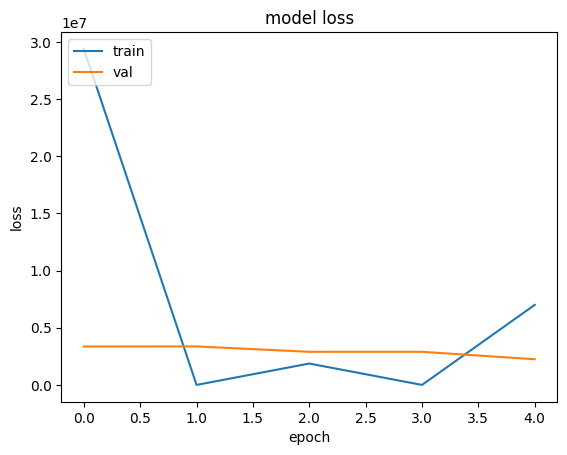

In [49]:
# Plotting the error
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [50]:
# Evaluate model
loss, mean_absolute_percentage_error = model.evaluate(test_generator)
print("Test MAPE:", mean_absolute_percentage_error)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


769/769 ━━━━━━━━━━━━━━━━━━━━ 507s 659ms/step - loss: 2264480.2500 - mean_absolute_percentage_error: 2264487.2500
Test MAPE: 2314240.75


In [62]:
test_label_df.head(20)

,screenshot,price
0,1351380_ss_2bcc7f9533f0f919845b6ae90f150c9f646...,499
1,1351380_ss_2f1977505466907f80566ad362ee103b23d...,499
2,1351380_ss_5219608855a31b5cdcf6d146fbc9f0730f4...,499
3,1351380_ss_601f501c43eecf7531e54e9d56e8031e3b3...,499
4,1351380_ss_8132494a97f0f66b6185d458c76401c9f34...,499
5,1351380_ss_ed065371f379d7e68a2bc0c1184159c0c91...,499
6,2507710_ss_0c8aeb898b2a2a360fd44fb34df73edd2af...,0
7,2507710_ss_1cdc718037f8806ddc59cc7d9de7f7d9735...,0
8,2507710_ss_76f764ed10ec5e8b639d8d3dceb3d1125ab...,0
9,2507710_ss_e817bf579c97e7437b026a7c84f8974cc0c...,0


Give the predicted price for a game


1351380_ss_2bcc7f9533f0f919845b6ae90f150c9f64611e7a.1920x1080.jpg


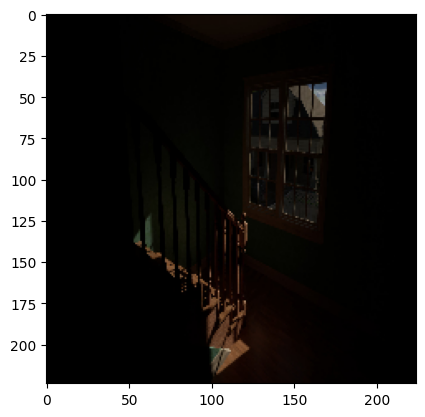

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
[[0.22011396]]
499


In [63]:
# Define the image location
number = 0
print(test_label_df.loc[number, "screenshot"])
filename = test_label_df.loc[number, "screenshot"]
#'620620_ss_01fe128c1e30f3cc9cee30fa4bbdb7f60e9abe67.1920x1080.jpg'

# Construct the full path to the image
image_path = os.path.join(image_location, filename)

# Load and display the image
img = keras.utils.load_img(image_path, target_size=(224, 224))
plt.imshow(img)
plt.show()

img_array = keras.utils.img_to_array(img)
img_array = keras.ops.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
print(predictions)
print(test_label_df.loc[number, "price"])




_________________________________________________________________________________________________________________________